# Model Explainability

In [1]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import make_column_selector as selector
from sklearn.pipeline import Pipeline

import xgboost
import shap

import matplotlib.pyplot as plt
import seaborn as sns

/Users/brianroepke/miniforge3/envs/ML/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv("bank.csv", delimiter=";")

In [3]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


In [4]:
df = df.drop(["duration"], axis=1)

## Prep

In [5]:
# Separate the target variable from the rest of the data
X = df.iloc[:, :-1]
y = df.iloc[:,-1]

In [6]:
column_trans = ColumnTransformer(transformers=
        [('num', MinMaxScaler(), selector(dtype_exclude="object")),
        ('cat', OrdinalEncoder(), selector(dtype_include="object"))],
        remainder='drop')
    

In [7]:
le = LabelEncoder()
y = le.fit_transform(y)

In [8]:
# Split the data into 30% test and 70% training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

## Coefficients in Logistic Regression

In [9]:
# Create a random forest classifier for feature importance
clf = LogisticRegression(random_state=42, 
                             max_iter=1000, 
                             class_weight='balanced')

pipeline = Pipeline([('prep',column_trans),
                        ('clf', clf)])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num', MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x17a0bdc40>),
                                                 ('cat', OrdinalEncoder(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x17a0bd610>)])),
                ('clf',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    random_state=42))])

In [10]:
pipeline['clf'].coef_[0]

array([ 0.75471553, -1.11473323, -0.0714886 , -3.2587945 ,  1.78373751,
        2.61506079,  0.02806859,  0.13490259,  0.1151557 ,  0.09080435,
       -0.47980448, -0.82908536, -0.5171127 ,  0.01441912,  0.14207762])

In [11]:
pipeline['clf'].intercept_[0]

-0.5418635990682154

In [12]:
feat_list = []
total_importance = 0
# Make a dataframe of Coeficients and Feature Names
for feature in zip(X, pipeline['clf'].coef_[0]):
    feat_list.append(feature)
    total_importance += feature[1]

# create DataFrame using data
df_imp = pd.DataFrame(feat_list, columns =['FEATURE', 'COEFFICIENT']).sort_values(by='COEFFICIENT', ascending=False)
df_imp.sort_values(by='COEFFICIENT', ascending=False)

,FEATURE,COEFFICIENT
5,balance,2.615061
4,default,1.783738
0,age,0.754716
14,poutcome,0.142078
7,loan,0.134903
8,contact,0.115156
9,day,0.090804
6,housing,0.028069
13,previous,0.014419
2,marital,-0.071489


## Feature Importances in Random Forest

In [13]:
# Create a random forest classifier for feature importance
clf = RandomForestClassifier(random_state=42, n_jobs=6, class_weight='balanced')

pipeline = Pipeline([('prep',column_trans),
                        ('clf', clf)])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num', MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x17a0bdc40>),
                                                 ('cat', OrdinalEncoder(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x17a0bd610>)])),
                ('clf',
                 RandomForestClassifier(class_weight='balanced', n_jobs=6,
                                        random_state=42))])

In [14]:
pipeline['clf'].feature_importances_

array([0.15169613, 0.1668886 , 0.13429024, 0.07288524, 0.05647985,
       0.02818437, 0.07880281, 0.03797838, 0.04328934, 0.00404282,
       0.02838248, 0.02165701, 0.04896554, 0.09215941, 0.03429777])

In [15]:
feat_list = []

total_importance = 0
# Print the name and gini importance of each feature
for feature in zip(X, pipeline['clf'].feature_importances_):
    feat_list.append(feature)
    total_importance += feature[1]
        
# create DataFrame using data
df_imp = pd.DataFrame(feat_list, columns =['FEATURE', 'IMPORTANCE']).sort_values(by='IMPORTANCE', ascending=False)
df_imp['CUMSUM'] = df_imp['IMPORTANCE'].cumsum()
df_imp

,FEATURE,IMPORTANCE,CUMSUM
1,job,0.166889,0.166889
0,age,0.151696,0.318585
2,marital,0.134290,0.452875
13,previous,0.092159,0.545034
6,housing,0.078803,0.623837
3,education,0.072885,0.696722
4,default,0.056480,0.753202
12,pdays,0.048966,0.802168
8,contact,0.043289,0.845457
7,loan,0.037978,0.883436


## SHAP

In [16]:
clf = xgboost.XGBRegressor()

pipeline = Pipeline([('prep',column_trans),
                        ('clf', clf)])

pipeline.fit(X_train, y_train);

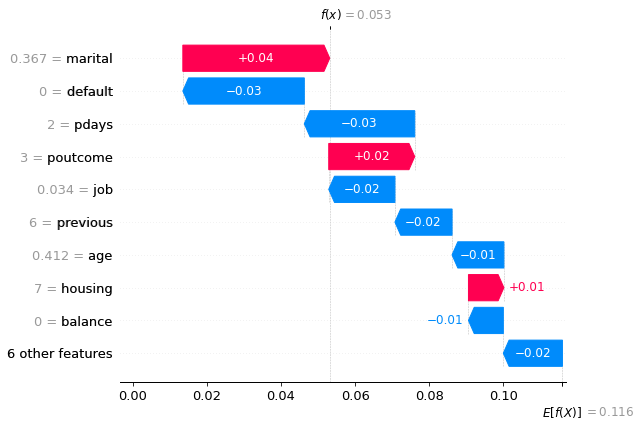

<Figure size 432x288 with 0 Axes>

In [18]:
model = pipeline['clf']

# explain the model's predictions using SHAP
explainer = shap.Explainer(model, 
                           pipeline['prep'].transform(X_train), 
                           feature_names=X_train.columns)
shap_values = explainer(pipeline['prep'].transform(X_train))

# visualize the first prediction's explanation
fig = shap.plots.waterfall(shap_values[1])
plt.tight_layout()
plt.savefig('explainability_01.png', dpi=300);
